# BADL-SGHMC FOR FORECASTING PHILIPPINE ECONOMIC GROWTH (E = .09 R = 1000)

<table align = "left">
<tr><td>author</td><td>AL-AHMADGAID B. ASAAD</td></tr>
<tr><td>thesis</td><td>Bayesian Autoregressive Distributed Lag *via* Stochastic Gradient Hamiltonian Monte Carlo</td></tr>
<tr><td>degree</td><td>Master of Science in Statistics</td></tr>
</table>


In [1]:
using DataFrames
using Distributions
using Gadfly
using StochMCMC
Gadfly.push_theme(:dark)

In [2]:
in_dir = joinpath(homedir(), "Dropbox/MS THESIS/JULIA/INPUT");
ou_Rdir = joinpath(homedir(), "Dropbox/MS THESIS/R/INPUT/PLOT");
lei_data = readtable(joinpath(in_dir, "SA RAW DATA W BOP.csv"));

lei_growth = lei_growth_std = zeros(nrow(lei_data) - 4, ncol(lei_data) - 1);

In [3]:
for j in 2:ncol(lei_data)
    for i in 5:nrow(lei_data)
        lei_growth[i - 4, j - 1] = ((lei_data[j][i] - lei_data[j][i - 4]) / lei_data[j][i - 4]) * 100
    end
    lei_growth_std[:, j - 1] = round((lei_growth[:, j - 1] - mean(lei_growth[:, j - 1])) ./ std(lei_growth[:, j - 1]), 3)
end

lei_df = DataFrame(lei_growth_std);
indicators =  DataFrame(lei_df);

writetable(joinpath(ou_Rdir, "SA GDP GROWTH.csv"), lei_df)

### Function for RMSE


In [4]:
function rmse(true_value::Array{Float64}, estimated_value::Array{Float64})
  sqrt((1 / length(true_value)) * sum((true_value - estimated_value) .^ 2))
end

rmse (generic function with 1 method)

## a. PRELIMINARIES
The following involves preparation of the data and the lag values of the dependent and predictors.

### a1. Data Partitioning

In [5]:
nrow(indicators)

67

In [6]:
# TRAINING
n_percent = .7
n_train = Int(nrow(indicators) * n_percent |> floor)
x = Array(indicators[1:n_train, 2:ncol(indicators)]);
y = Array(indicators[1:n_train, 1]);

# Testing
x_test = Array(indicators[(n_train + 1):end, 2:ncol(indicators)]);
y_test = Array(indicators[(n_train + 1):end, 1]);

In [40]:
n_train/4

11.5

In [7]:
x

46×4 Array{Float64,2}:
  0.459  -0.842   1.609  -0.001
  1.096  -1.891   1.123  -0.141
  1.68   -1.751   0.811  -0.03 
  2.609  -1.687   0.759  -0.069
  2.407  -0.843   0.232  -0.137
  2.452  -0.783  -0.01    0.602
  1.832  -0.992  -0.227   0.089
  0.491  -1.266  -0.554  -0.186
  0.384  -0.899   0.7    -0.72 
 -0.263  -0.776   0.386  -0.108
 -0.334  -0.845  -0.237  -0.061
  0.172  -0.63   -0.296  -0.244
  0.51   -1.417  -0.925  -0.192
  ⋮                            
 -0.289  -1.414   0.919  -0.275
  1.39   -2.283   1.221  -0.093
  1.895  -1.974   1.378   0.195
  1.228  -0.97    0.762  -3.405
  0.557  -0.099   0.608  -0.267
 -0.604   1.781   0.214  -0.027
 -0.638   2.003  -0.035  -0.079
 -0.793   1.285   0.214  -0.089
 -0.924   0.799   0.256   0.013
 -1.018   1.095   1.462  -0.09 
 -0.783   0.675   2.124  -0.094
 -0.801   0.729   2.367  -0.032

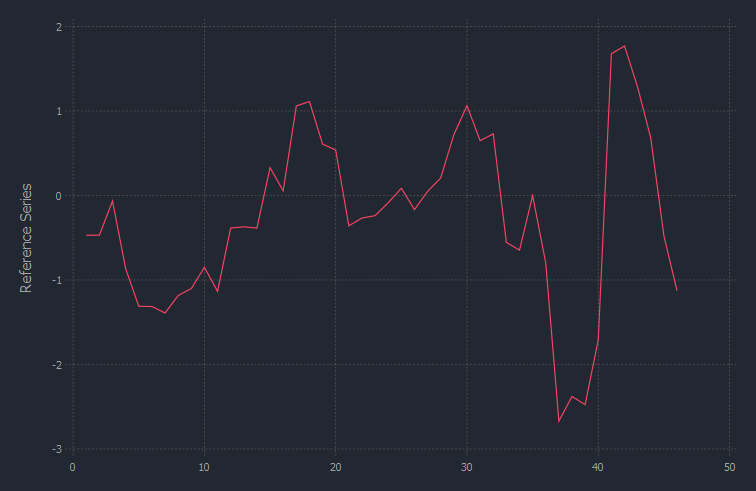

In [8]:
series = DataFrame(Y = y);
p = plot(series, y = :Y, Geom.line, Guide.ylabel("Reference Series"))
draw(PNG(20cm, 13cm), p)

### a2. Define lag values of Ys and Xs

In [9]:
y_1 = [mean(y[1:(end - 1)]); y[1:(end - 1)]];
x_1 = [mapslices(mean, x[1:(end - 1), :], [1]); x[1:(end - 1), :]];
n_params = 1 + length(size(y_1)) + size(x)[2] + size(x_1)[2]

y_1test = [mean(y_test[1:(end - 1)]); y_test[1:(end - 1)]];
x_1test = [mapslices(mean, x_test[1:(end - 1), :], [1]); x_test[1:(end - 1), :]];

### a3. Define log Prior, log Likelihood and log Posterior

In [10]:
"""
The log likelihood function is given by the following codes:
"""
function loglike(theta::Array{Float64})
  yhat = theta[1] + theta[2] * y_1
  for i in 1:(size(x)[2])
    yhat += theta[i + 2] * x[:, i] + theta[i + 2 + size(x)[2]] * x_1[:, i]
  end

  likhood = Float64[]
  for i in 1:length(yhat)
    push!(likhood, log(pdf(Normal(yhat[i], alpha), y[i])))
  end

  return likhood |> sum
end

"""
Define the Prior Distribution
"""
function logprior(theta::Array{Float64})
  w_prior = [log(pdf(Normal(mu[i], s[i]), theta[i])) for i in 1:(n_params)]

  return w_prior |> sum
end

"""
Define the Posterior Distribution
"""
function logpost(theta::Array{Float64})
  loglike(theta) + logprior(theta)
end

logpost

Define Necesarry Parameters

In [11]:
alpha = 1 / 5.;
mu = zeros(n_params);
s = ones(n_params);
n_chain = 4;
R = 1000;
eps = .09;

## b. METROPOLIS-HASTING

In [12]:
chain1 = Dict{Symbol, Array{Float64}}()

srand(123);
for i in 1:n_chain
  init_val = rand(Uniform(.001 + (i - 1) / 4, i / 4), n_params)
  mh_object = MH(logpost; init_est = init_val, d = n_params);
  chain1[Symbol("Realization_" * string(i))] = mcmc(mh_object, r = R);
end

In [13]:
for i in 1:n_chain
    writetable(joinpath(ou_Rdir, "MH Chain Eps = .09 R = 1000 " * string(i) * ".csv"), DataFrame(chain1[Symbol("Realization_" * string(i))]))
end

### b1. Plot: Training Data

In [14]:
"""
Plot it
"""
series = DataFrame(Y = y);
burnIn = 10;
stepsize = 10;

# Training Data
chain1_ave = zeros(R, n_params);
for i in 1:R
  chain1_vec = [chain1[collect(keys(chain1))[1]][i, :] chain1[collect(keys(chain1))[2]][i, :] chain1[collect(keys(chain1))[3]][i, :] chain1[collect(keys(chain1))[4]][i, :]]'
  chain1_ave[i, :] = mapslices(mean, chain1_vec, [1])
end

est1 = mapslices(mean, chain1_ave, [1]);
std1 = mapslices(std, chain1_ave, [1]);

writetable(joinpath(ou_Rdir, "MH Chain Ave Eps = .09 R = 1000.csv"), DataFrame(chain1_ave))

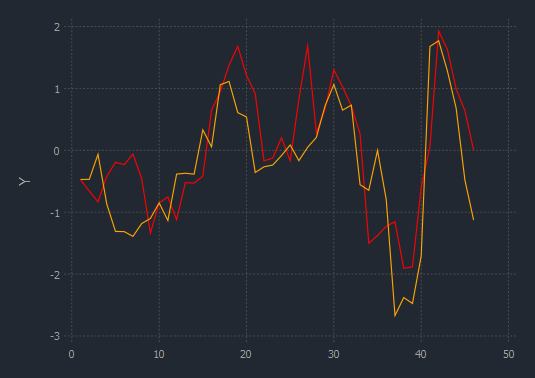

In [15]:
yhat = est1[1] + est1[2] * y_1
for i in 1:(size(x)[2])
  yhat += est1[i + 2] * x[:, i] + est1[i + 2 + size(x)[2]] * x_1[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)

rmse_ch1_train = rmse(y, yhat_std)
series[:yhat_std] = yhat_std;

plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red")))

In [16]:
for i in (burnIn + 1):stepsize:size(chain1_ave)[1]
  yhat = chain1_ave[i, 1] + chain1_ave[i, 2] * y_1
  for j in 1:(size(x)[2])
    yhat += chain1_ave[i, j + 2] * x[:, j] + chain1_ave[i, j + 2 + size(x)[2]] * x_1[:, j]
  end

  series[Symbol("yhat_std_", string(i))] = (yhat - mean(yhat)) / std(yhat);
end

series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series)), outer = size(chain1_ave[(burnIn + 1):stepsize:end, :])[1]),
  var = Array(stack(series[:, 3:end])[1]),
  val = Array(stack(series[:, 3:end])[2])
  );

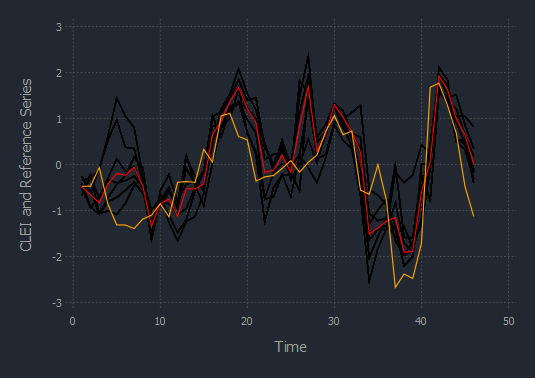

In [17]:
writetable(joinpath(ou_Rdir, "MH Train Out Eps = .09 R = 1000.csv"), series)

p2_mhi = plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("CLEI and Reference Series")
)

### b2. Plot: Testing Data

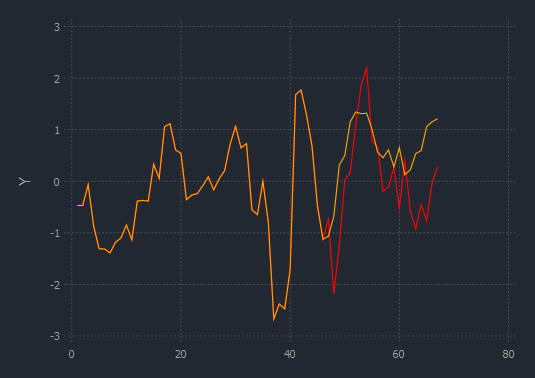

In [18]:
# Testing Data
yhat = est1[1] + est1[2] * y_1test
for i in 1:(size(x)[2])
  yhat += est1[i + 2] * x_test[:, i] + est1[i + 2 + size(x)[2]] * x_1test[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)

rmse_ch1 = rmse(y_test, yhat_std)

series_test = DataFrame(Y = Array(indicators[:, 1]));
series_test[:yhat_std] = [y; yhat_std];

plot(layer(series_test, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series_test, y = :yhat_std, Geom.line, style(default_color = colorant"red"))
)

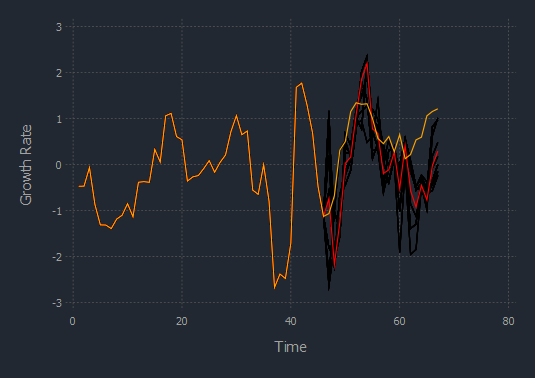

In [19]:
for i in (burnIn + 1):stepsize:size(chain1_ave)[1]
  yhat = chain1_ave[i, 1] + chain1_ave[i, 2] * y_1test
  for j in 1:(size(x)[2])
    yhat += chain1_ave[i, j + 2] * x_test[:, j] + chain1_ave[i, j + 2 + size(x)[2]] * x_1test[:, j]
  end

  series_test[Symbol("yhat_std_", string(i))] = [y; (yhat - mean(yhat)) / std(yhat)];
end

series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series_test)), outer = size(chain1_ave[(burnIn + 1):stepsize:end, :])[1]),
  var = Array(stack(series_test[:, 3:end])[1]),
  val = Array(stack(series_test[:, 3:end])[2])
  );

writetable(joinpath(ou_Rdir, "MH Test Out Eps = .09 R = 1000.csv"), series_test)
plot(layer(series_test, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series_test, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("Growth Rate")
)

## c. HAMILTONIAN MONTE CARLO

In [20]:
U(theta::Array{Float64}) = - logpost(theta)
K(p::Array{Float64}; Σ = eye(length(p))) = (p' * inv(Σ) * p) / 2
function dU(theta::Array{Float64})
  yhat = theta[1] + theta[2] * y_1
  for i in 1:(size(x)[2])
    yhat += theta[i + 2] * x[:, i] + theta[i + 2 + size(x)[2]] * x_1[:, i]
  end
  vcat(
      [-alpha * sum((y - yhat)) + s[1] * theta[1]],
      [-alpha * sum((y - yhat) .* y_1) + s[1] * theta[1]],
      [-alpha * sum((y - yhat) .* x[:, i]) + s[i + 1] * theta[i + 1] for i in 1:size(x)[2]],
      [-alpha * sum((y - yhat) .* x_1[:, i]) + s[i + 2 + size(x)[2]] * theta[i + 2 + size(x)[2]] for i in 1:size(x)[2]]
  )
end
dK(p::Array{Float64}; Σ::Array{Float64} = eye(length(p))) = inv(Σ) * p;

chain2 = Dict{Symbol, Array{Float64}}()

Dict{Symbol,Array{Float64,N}} with 0 entries

In [21]:
srand(123);
for i in 1:n_chain
  init_val = rand(Uniform(.001 + (i - 1) / 4, i / 4), n_params)
  HMC_object = HMC(U, K, dU, dK, init_val, n_params);
  chain2[Symbol("Realization_" * string(i))] = mcmc(HMC_object, leapfrog_params = Dict([:ɛ => eps, :τ => 20]), r = R);
end

In [22]:
for i in 1:n_chain
    writetable(joinpath(ou_Rdir, "HMC Chain Eps = .09 R = 1000 " * string(i) * ".csv"), DataFrame(chain2[Symbol("Realization_" * string(i))]))
end

### c1. Plot: Training

In [23]:
"""
Plot it
"""
series = DataFrame(Y = y);
burnIn = 10;
stepsize = 10;

# Training Data

chain2_ave = zeros(R, n_params);
for i in 1:R
  chain2_vec = [chain2[collect(keys(chain2))[1]][i, :] chain2[collect(keys(chain2))[2]][i, :] chain2[collect(keys(chain2))[3]][i, :] chain2[collect(keys(chain2))[4]][i, :]]'
  chain2_ave[i, :] = mapslices(mean, chain2_vec, [1])
end

est2 = mapslices(mean, chain2_ave, [1]);
std2 = mapslices(std, chain2_ave, [1]);

writetable(joinpath(ou_Rdir, "HMC Chain Ave Eps = .09 R = 1000.csv"), DataFrame(chain2_ave))

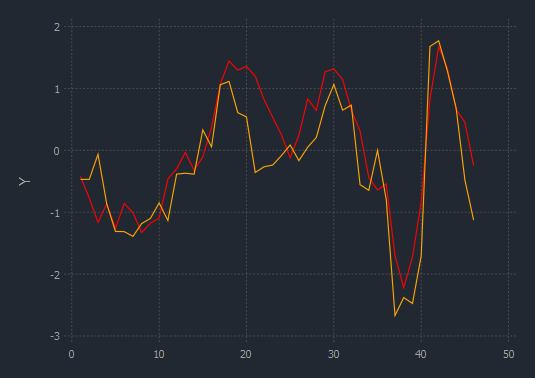

In [24]:
yhat = est2[1] + est2[2] * y_1
for i in 1:(size(x)[2])
  yhat += est2[i + 2] * x[:, i] + est2[i + 2 + size(x)[2]] * x_1[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)
rmse_ch2_train = rmse(y, yhat_std)
series[:yhat_std] = yhat_std;

plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red"))
)

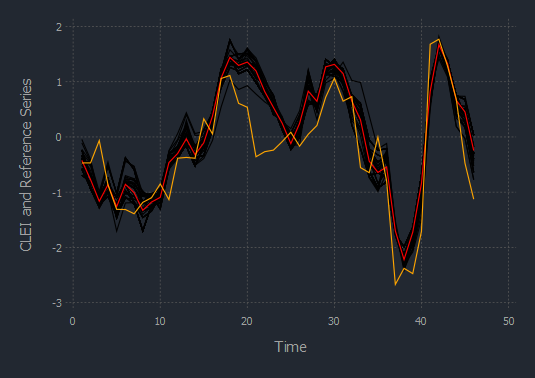

In [25]:
for i in (burnIn + 1):stepsize:size(chain2_ave)[1]
  yhat = chain2_ave[i, 1] + chain2_ave[i, 2] * y_1
  for j in 1:(size(x)[2])
    yhat += chain2_ave[i, j + 2] * x[:, j] + chain2_ave[i, j + 2 + size(x)[2]] * x_1[:, j]
  end

  series[Symbol("yhat_std_", string(i))] = (yhat - mean(yhat)) / std(yhat);
end

series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series)), outer = size(chain2_ave[(burnIn + 1):stepsize:end, :])[1]),
  var = Array(stack(series[:, 3:end])[1]),
  val = Array(stack(series[:, 3:end])[2])
  );

writetable(joinpath(ou_Rdir, "HMC Train Out Eps = .09 R = 1000.csv"), series)
plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("CLEI and Reference Series")
)

### c2. Plot: Testing

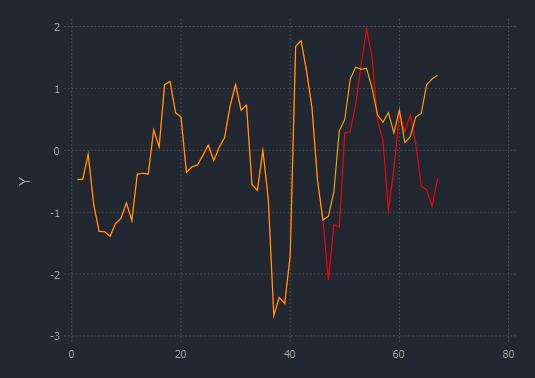

In [26]:
# Testing Data
yhat = est2[1] + est2[2] * y_1test
for i in 1:(size(x)[2])
  yhat += est2[i + 2] * x_test[:, i] + est2[i + 2 + size(x)[2]] * x_1test[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)

rmse_ch2 = rmse(y_test, yhat_std)

series_test = DataFrame(Y = Array(indicators[:, 1]));
series_test[:yhat_std] = [y; yhat_std];

plot(layer(series_test, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series_test, y = :yhat_std, Geom.line, style(default_color = colorant"red"))
)

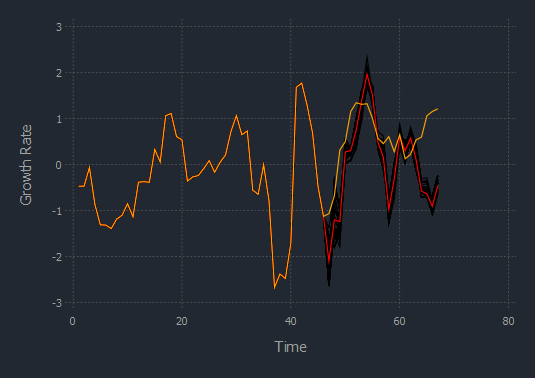

In [27]:
for i in (burnIn + 1):stepsize:size(chain2_ave)[1]
  yhat = chain2_ave[i, 1] + chain2_ave[i, 2] * y_1test
  for j in 1:(size(x)[2])
    yhat += chain2_ave[i, j + 2] * x_test[:, j] + chain2_ave[i, j + 2 + size(x)[2]] * x_1test[:, j]
  end

  series_test[Symbol("yhat_std_", string(i))] = [y; (yhat - mean(yhat)) / std(yhat)];
end

series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series_test)), outer = size(chain2_ave[(burnIn + 1):stepsize:end, :])[1]),
  var = Array(stack(series_test[:, 3:end])[1]),
  val = Array(stack(series_test[:, 3:end])[2])
  );

writetable(joinpath(ou_Rdir, "HMC Test Out Eps = .09 R = 1000.csv"), series_test)
plot(layer(series_test, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series_test, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("Growth Rate")
)

## d. STOCHASTIC GRADIENT HAMILTONIAN MONTE CARLO

In [28]:
function dU_noise(theta::Array{Float64})
  yhat = theta[1] + theta[2] * y_1
  for i in 1:(size(x)[2])
    yhat += theta[i + 2] * x[:, i] + theta[i + 2 + size(x)[2]] * x_1[:, i]
  end
  vcat(
      [-alpha * sum((y - yhat)) + s[1] * theta[1]],
      [-alpha * sum((y - yhat) .* y_1) + s[1] * theta[1]],
      [-alpha * sum((y - yhat) .* x[:, i]) + s[i + 1] * theta[i + 1] for i in 1:size(x)[2]],
      [-alpha * sum((y - yhat) .* x_1[:, i]) + s[i + 2 + size(x)[2]] * theta[i + 2 + size(x)[2]] for i in 1:size(x)[2]]
  ) + randn(n_params)
end

dU_noise (generic function with 1 method)

In [29]:
srand(123);
chain3 = Dict{Symbol, Array{Float64}}()
for i in 1:n_chain
  init_val = rand(Uniform(.001 + (i - 1) / 4, i / 4), n_params)
  SGHMC_object = SGHMC(dU_noise, dK, eye(n_params), eye(n_params), eye(n_params), init_val, n_params * 1.);
    chain3[Symbol("Realization_" * string(i))] = mcmc(SGHMC_object, leapfrog_params = Dict([:ɛ => eps, :τ => 20]), r = R);
end

In [30]:
for i in 1:n_chain
    writetable(joinpath(ou_Rdir, "SGHMC Chain Eps = .09 R = 1000 " * string(i) * ".csv"), DataFrame(chain3[Symbol("Realization_" * string(i))]))
end

In [31]:
"""
Plot it
"""
series = DataFrame(Y = y);
burnIn = 10;
stepsize = 10;

# Training Data
chain3_ave = zeros(R, n_params);
for i in 1:R
  chain3_vec = [chain3[collect(keys(chain3))[1]][i, :] chain3[collect(keys(chain3))[2]][i, :] chain3[collect(keys(chain3))[3]][i, :] chain3[collect(keys(chain3))[4]][i, :]]'
  chain3_ave[i, :] = mapslices(mean, chain3_vec, [1])
end

est3 = mapslices(mean, chain3_ave, [1]);
std3 = mapslices(std, chain3_ave, [1]);

writetable(joinpath(ou_Rdir, "SGHMC Chain Ave Eps = .09 R = 1000.csv"), DataFrame(chain3_ave))

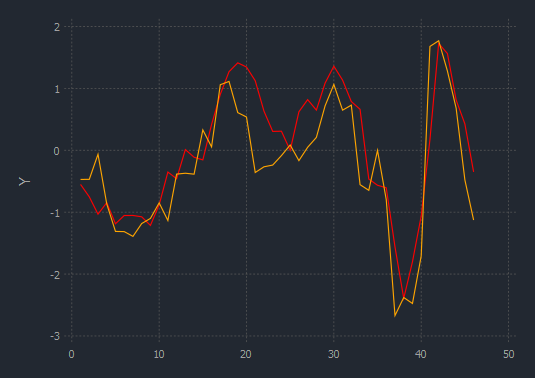

In [32]:
yhat = est3[1] + est3[2] * y_1
for i in 1:(size(x)[2])
  yhat += est3[i + 2] * x[:, i] + est3[i + 2 + size(x)[2]] * x_1[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)
rmse_ch3_train = rmse(y, yhat_std)
series[:yhat_std] = yhat_std;

plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red"))
)

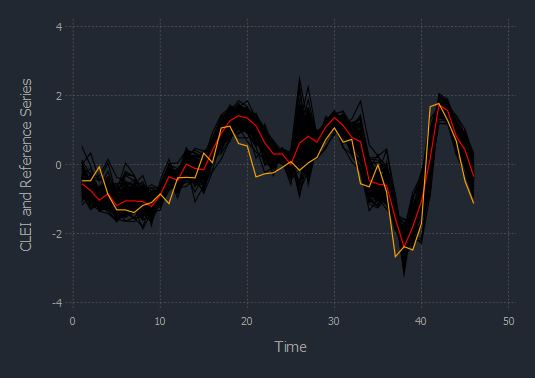

In [33]:
for i in (burnIn + 1):stepsize:size(chain3_ave)[1]
  yhat = chain3_ave[i, 1] + chain3_ave[i, 2] * y_1
  for j in 1:(size(x)[2])
    yhat += chain3_ave[i, j + 2] * x[:, j] + chain3_ave[i, j + 2 + size(x)[2]] * x_1[:, j]
  end

  series[Symbol("yhat_std_", string(i))] = (yhat - mean(yhat)) / std(yhat);
end

series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series)), outer = size(chain3_ave[(burnIn + 1):stepsize:end, :])[1]),
  var = Array(stack(series[:, 3:end])[1]),
  val = Array(stack(series[:, 3:end])[2])
  );

writetable(joinpath(ou_Rdir, "SGHMC Train Out Eps = .09 R = 1000.csv"), series)
plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("CLEI and Reference Series")
)

### d Plot: Testing

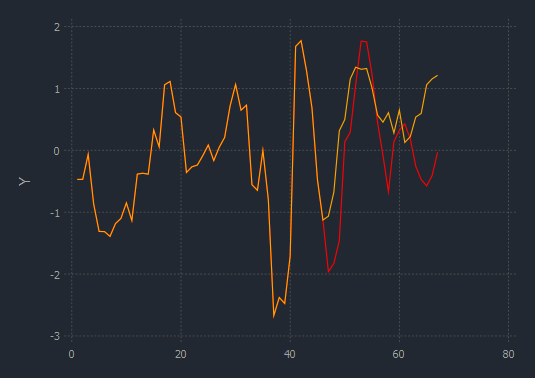

In [34]:
# Testing Data
yhat = est3[1] + est3[2] * y_1test
for i in 1:(size(x)[2])
  yhat += est3[i + 2] * x_test[:, i] + est3[i + 2 + size(x)[2]] * x_1test[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)

rmse_ch3 = rmse(y_test, yhat_std)

series_test = DataFrame(Y = Array(indicators[:, 1]));
series_test[:yhat_std] = [y; yhat_std];

plot(layer(series_test, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series_test, y = :yhat_std, Geom.line, style(default_color = colorant"red"))
)

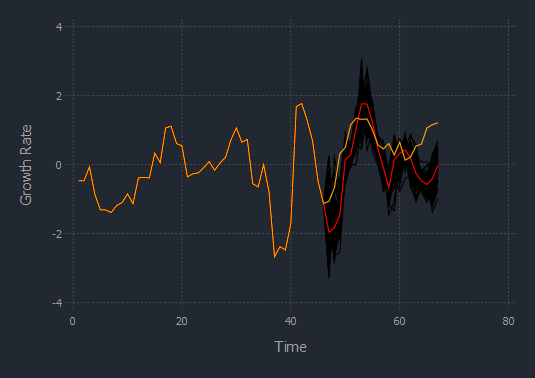

In [35]:
for i in (burnIn + 1):stepsize:size(chain3_ave)[1]
  yhat = chain3_ave[i, 1] + chain3_ave[i, 2] * y_1test
  for j in 1:(size(x)[2])
    yhat += chain3_ave[i, j + 2] * x_test[:, j] + chain3_ave[i, j + 2 + size(x)[2]] * x_1test[:, j]
  end

  series_test[Symbol("yhat_std_", string(i))] = [y; (yhat - mean(yhat)) / std(yhat)];
end

series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series_test)), outer = size(chain3_ave[(burnIn + 1):stepsize:end, :])[1]),
  var = Array(stack(series_test[:, 3:end])[1]),
  val = Array(stack(series_test[:, 3:end])[2])
  );

writetable(joinpath(ou_Rdir, "SGHMC Test Out Eps = .09 R = 1000.csv"), series_test)
plot(layer(series_test, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series_test, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("Growth Rate")
)

In [36]:
writetable(joinpath(ou_Rdir, "Coefficients Eps = .09 R = 1000.csv"), DataFrame([round(est1, 3); round(std1, 3); round(est2, 3); round(std2, 3); round(est3, 3); round(std3, 3)]'));

In [37]:
writetable(joinpath(ou_Rdir, "RMSE Train Eps = .09 R = 1000.csv"), DataFrame(MH = round(rmse_ch1_train, 3), HMC = round(rmse_ch2_train, 3), SGHMC = round(rmse_ch3_train, 3)))

In [38]:
writetable(joinpath(ou_Rdir, "RMSE Testing Eps = .09 R = 1000.csv"), DataFrame(MH = round(rmse_ch1, 3), HMC = round(rmse_ch2, 3), SGHMC = round(rmse_ch3, 3)))